In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.pyplot import figure
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from category_encoders import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sqlalchemy.sql.functions import concat
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn import metrics

In [2]:
df = pd.read_excel("train.xlsx")

In [381]:
df_select = df.copy()

In [383]:
loan_status_mapping = {
    'Fully Paid': 0,
    'Charged Off': 1,
    'Default': 1
}

df_select['loan_status'] = df_select['loan_status'].map(loan_status_mapping)
df_select['loan_status'].value_counts()

loan_status
0    70427
1    18655
Name: count, dtype: int64

In [385]:
df_select = df_select[['annual_inc', 'emp_length', 'verification_status', 'term', 'installment', 'sub_grade', 'purpose',
         'fico_range_high', 'dti', 'avg_cur_bal', 'bc_open_to_buy', 'open_acc', 'revol_util', 'total_acc', 'earliest_cr_line',
        'total_rev_hi_lim', 'acc_open_past_24mths', 'mort_acc', 'tot_hi_cred_lim', 'loan_status']]

# Định nghĩa các danh sách cột
num_feature = ['annual_inc', 'installment', 'fico_range_high', 'dti', 'avg_cur_bal', 'bc_open_to_buy', 
                'open_acc', 'revol_util', 'total_acc', 'total_rev_hi_lim',
               'acc_open_past_24mths', 'mort_acc', 'tot_hi_cred_lim']
cat_feature = ['emp_length', 'verification_status', 'term', 'sub_grade', 'purpose']
date_feature = ['earliest_cr_line']


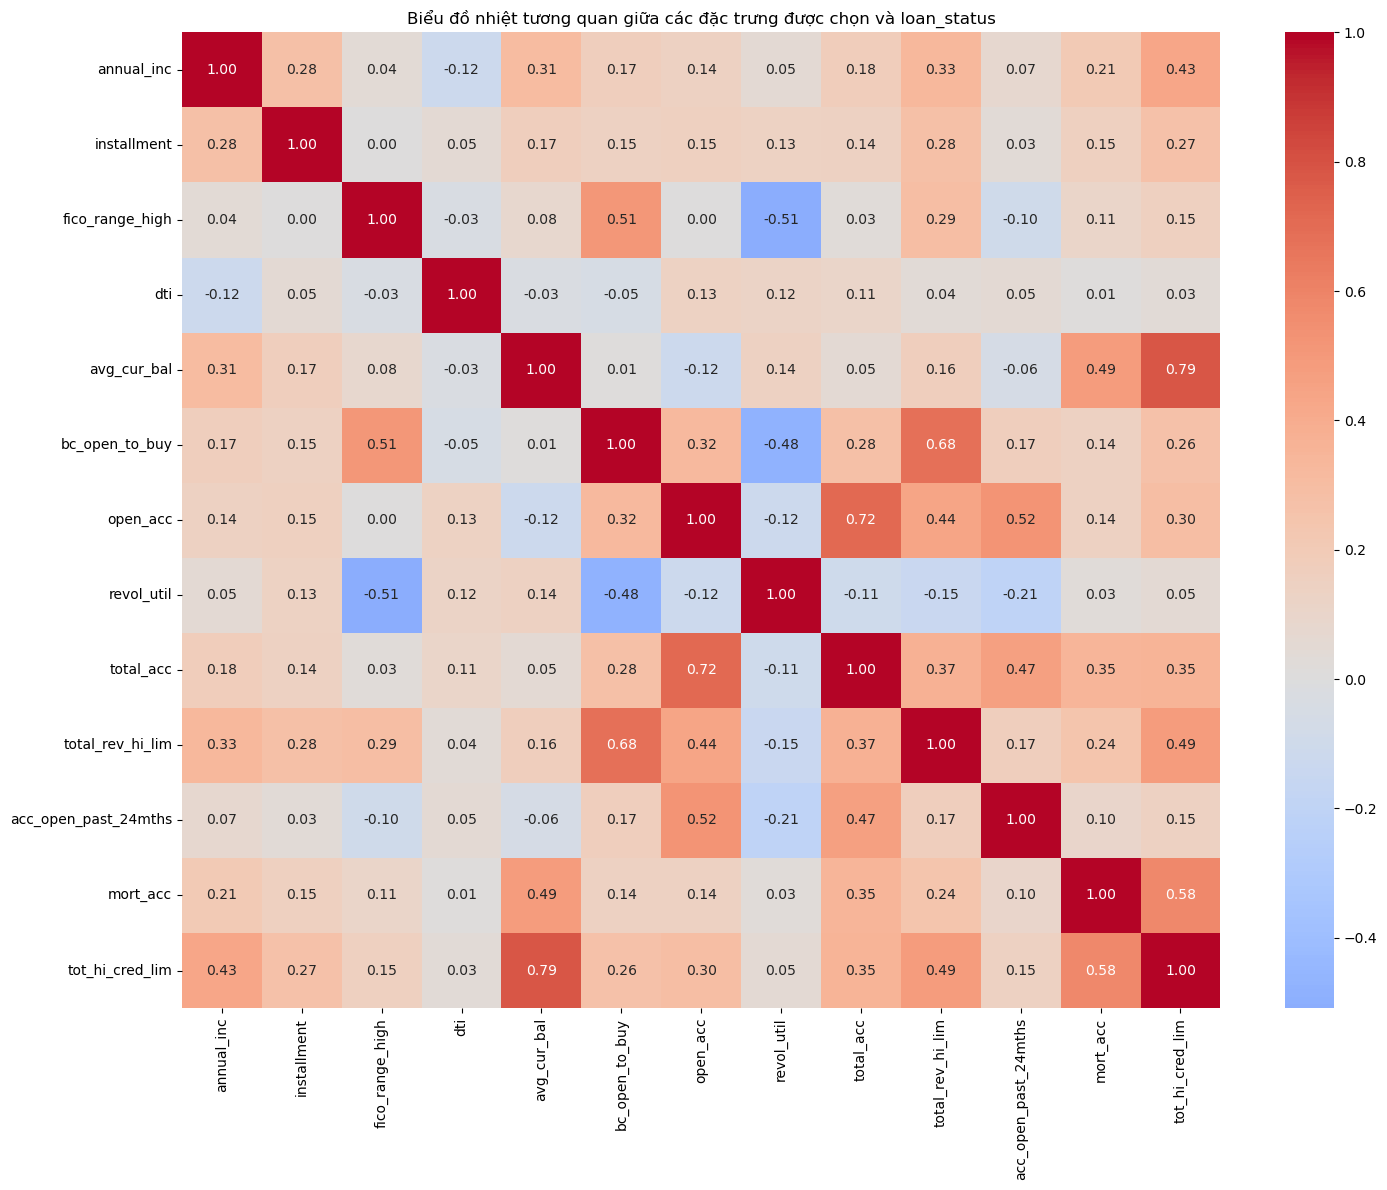

In [387]:
# Tính ma trận tương quan
corr_matrix = df[num_feature].corr()

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(15, 12))

# Tạo biểu đồ nhiệt
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')

# Đặt tiêu đề
plt.title('Biểu đồ nhiệt tương quan giữa các đặc trưng được chọn và loan_status')

# Hiển thị biểu đồ
plt.tight_layout()
plt.show()

In [389]:
# điền giá trị missing
columns_to_fill = ['dti', 'revol_util', 'bc_open_to_buy', 'avg_cur_bal'] 

for col in columns_to_fill:
    median_value = df_select[col].median()
    df_select[col] = df_select[col].fillna(median_value)

mode_value = df_select['emp_length'].mode()[0]
df_select['emp_length'] = df_select['emp_length'].fillna(mode_value)


In [391]:
# Tạo cột credit_years từ earliest_cr_line
df_select['credit_years'] = (pd.Timestamp.today() - df_select['earliest_cr_line']).dt.days / 365.25
df_select['credit_years'] = df_select['credit_years'].astype(float)

# Xóa cột earliest_cr_line vì đã chuyển thành credit_years
df_select = df_select.drop('earliest_cr_line', axis=1)

In [393]:
# Cột purpose
df_select.loc[df_select['purpose'].isin(['major_purchase', 'medical', 'car', 'vacation', 
                           'small_business', 'house', 'moving', 'renewable_energy', 'wedding']), 'purpose'] = 'Other'

In [395]:
term_values = {' 36 months': 36, ' 60 months': 60}
df_select['term'] = df_select.term.map(term_values)

In [397]:
# Định nghĩa lại các danh sách cột
num_feature = ['annual_inc', 'installment', 'fico_range_high', 'dti', 'avg_cur_bal', 'bc_open_to_buy', 
                'open_acc', 'revol_util', 'total_acc', 'total_rev_hi_lim',
               'acc_open_past_24mths', 'mort_acc', 'tot_hi_cred_lim', 'credit_years']
ordinal_feature = ['sub_grade', 'emp_length']
nominal_feature = ['verification_status', 'purpose', 'term']

In [399]:
from sklearn.feature_selection import VarianceThreshold
variance_threshold = VarianceThreshold(threshold=1)
variance_threshold.fit(df_select[num_feature])
print(variance_threshold.variances_)
print(variance_threshold.get_support())

[4.89608218e+09 8.42652653e+04 1.29890711e+03 3.89579140e+02
 3.05287794e+08 3.39799842e+08 3.37743446e+01 6.44029602e+02
 1.52552592e+02 1.20426908e+09 1.17185393e+01 3.18196114e+00
 3.38884587e+10 5.74639798e+01]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


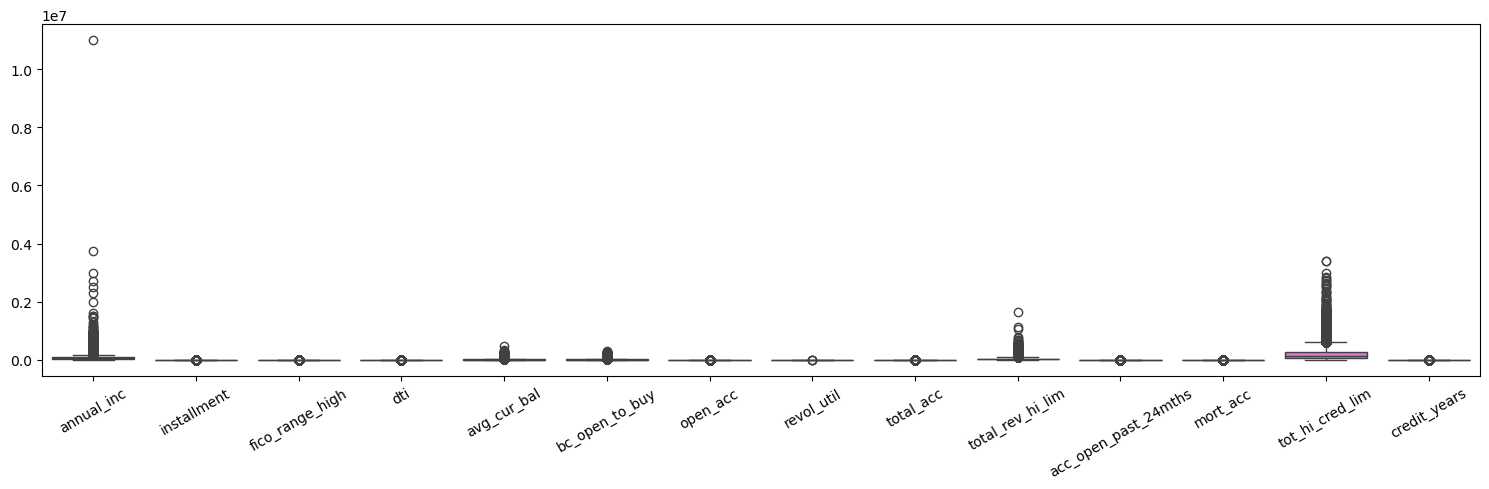

In [291]:
plt.figure(figsize = (15, 5))
sns.boxplot(data = df_select[num_feature])
plt.xticks(rotation = 30)
plt.tight_layout()
plt.show()

In [401]:
def handle_outliers(df, column):
    Q1 = df_select[num_feature].quantile(0.25)
    Q3 = df_select[num_feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Thay outlier nhỏ hơn lower_bound bằng Q1
    df_select[num_feature] = np.where(df_select[num_feature] < lower_bound, Q1, df_select[num_feature])

    # Thay outlier lớn hơn upper_bound bằng Q3
    df_select[num_feature] = np.where(df_select[num_feature] > upper_bound, Q3, df_select[num_feature])

    return df_select

# Xử lý outlier cho từng cột
for col in num_feature:
    df_select = handle_outliers(df_select, col)


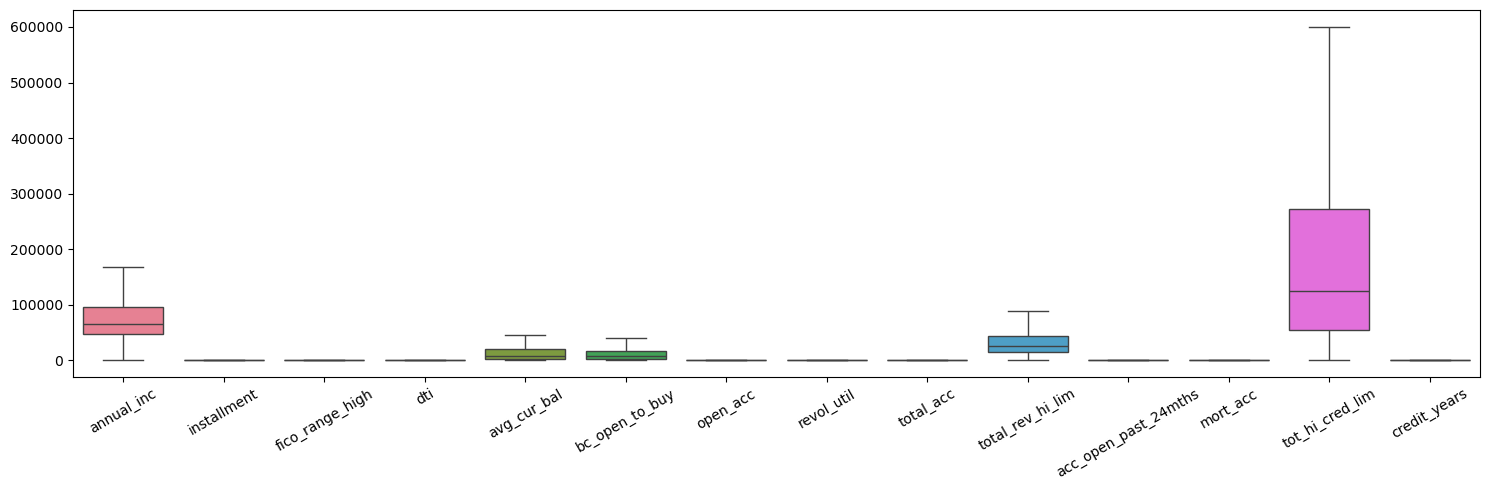

In [243]:
plt.figure(figsize = (15, 5))
sns.boxplot(data = df_select[num_feature])
plt.xticks(rotation = 30)
plt.tight_layout()
plt.show()

In [207]:
df_select[df_select['loan_status'] == 0].head()

,annual_inc,emp_length,verification_status,term,installment,sub_grade,purpose,fico_range_high,dti,avg_cur_bal,bc_open_to_buy,open_acc,revol_util,total_acc,total_rev_hi_lim,acc_open_past_24mths,mort_acc,tot_hi_cred_lim,loan_status,credit_years
0,52000.0,9 years,Source Verified,36,93.10,A4,Other,764.0,0.58,25099.0,30359.0,7.0,0.5,30.0,31000.0,3.0,4.0,191216.0,0,27.364819
1,55000.0,10+ years,Not Verified,36,166.03,B5,other,679.0,14.18,2222.0,10551.0,14.0,33.9,24.0,33800.0,2.0,0.0,61551.0,0,23.783710
2,40000.0,< 1 year,Verified,36,232.44,B5,home_improvement,699.0,20.25,10977.0,4996.0,13.0,36.0,29.0,13900.0,4.0,0.0,132817.0,0,18.203970
3,57000.0,10+ years,Verified,36,587.24,D5,debt_consolidation,684.0,27.58,14324.0,19752.0,11.0,53.2,26.0,55500.0,5.0,2.0,188780.0,0,25.117043
4,85000.0,10+ years,Source Verified,60,560.94,D4,Other,669.0,15.76,8551.0,16684.0,15.0,34.2,27.0,42700.0,8.0,3.0,172433.0,0,16.531143


In [403]:
X = df_select.drop('loan_status', axis=1)
y = df_select['loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

X_train.shape, y_train.shape
X_test.shape, y_test.shape

((26725, 19), (26725,))

In [405]:
ord = OrdinalEncoder(categories=
                     [['A1', 'A2', 'A3', 'A4', 'A5', 'B1', 'B2', 'B3', 'B4', 'B5', 'C1', 'C2','C3', 'C4', 'C5', 'D1', 'D2', 'D3', 'D4', 
                       'D5', 'E1', 'E2', 'E3', 'E4', 'E5', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5'],
                     ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', '8 years', '9 years', '10+ years']
                     ])
X_train[ordinal_feature] = ord.fit_transform(X_train[ordinal_feature])
X_test[ordinal_feature] = ord.transform(X_test[ordinal_feature])

X_train

,annual_inc,emp_length,verification_status,term,installment,sub_grade,purpose,fico_range_high,dti,avg_cur_bal,bc_open_to_buy,open_acc,revol_util,total_acc,total_rev_hi_lim,acc_open_past_24mths,mort_acc,tot_hi_cred_lim,credit_years
49408,57480.0,10.0,Not Verified,60,389.36,17.0,debt_consolidation,674.0,12.73,4171.0,949.0,5.0,88.5,7.0,15500.0,3.0,0.0,38027.0,26.872005
7092,40000.0,7.0,Source Verified,36,117.93,13.0,Other,704.0,25.77,13031.0,9527.0,8.0,58.9,14.0,24000.0,4.0,2.0,105000.0,33.284052
25555,26400.0,10.0,Verified,36,211.01,14.0,debt_consolidation,664.0,36.68,9309.0,1854.0,7.0,59.3,14.0,5400.0,9.0,2.0,76486.0,31.367556
27444,95000.0,2.0,Source Verified,36,587.24,3.0,other,724.0,20.13,23079.0,17488.0,4.0,2.6,16.0,45800.0,2.0,0.0,145350.0,25.872690
34777,40000.0,3.0,Source Verified,36,321.28,15.0,debt_consolidation,704.0,25.41,2207.0,5356.0,12.0,45.7,19.0,23100.0,6.0,0.0,53597.0,23.701574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74768,39500.0,2.0,Source Verified,36,218.17,9.0,debt_consolidation,739.0,25.98,3609.0,10497.0,14.0,20.0,51.0,35000.0,13.0,0.0,147034.0,15.121150
3572,56000.0,10.0,Not Verified,36,180.67,0.0,credit_card,739.0,4.32,519.0,17488.0,10.0,7.4,26.0,69800.0,8.0,0.0,69800.0,38.620123
29463,30675.0,2.0,Source Verified,36,434.36,6.0,debt_consolidation,764.0,19.84,6132.0,17387.0,11.0,22.5,33.0,31900.0,5.0,1.0,108455.0,19.953457
17399,46000.0,0.0,Source Verified,36,973.95,7.0,other,689.0,2.54,90.0,33136.0,17.0,2.4,29.0,60000.0,5.0,0.0,60000.0,17.872690


In [407]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
ohe.fit(X_train[nominal_feature])

# Transform tập X_train
X_train_ohe = pd.DataFrame(
    ohe.transform(X_train[nominal_feature]),
    columns=ohe.get_feature_names_out(nominal_feature),
    index=X_train.index
)

# Transform tập X_test
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[nominal_feature]),
    columns=ohe.get_feature_names_out(nominal_feature),
    index=X_test.index
)

# Xóa cột và concat cột mới
X_train = X_train.drop(nominal_feature, axis=1)
X_test = X_test.drop(nominal_feature, axis=1)

X_train = pd.concat([X_train, X_train_ohe], axis=1)
X_test = pd.concat([X_test, X_test_ohe], axis=1)

X_train

,annual_inc,emp_length,installment,sub_grade,fico_range_high,dti,avg_cur_bal,bc_open_to_buy,open_acc,revol_util,...,mort_acc,tot_hi_cred_lim,credit_years,verification_status_Source Verified,verification_status_Verified,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_other,term_60
49408,57480.0,10.0,389.36,17.0,674.0,12.73,4171.0,949.0,5.0,88.5,...,0.0,38027.0,26.872005,0.0,0.0,0.0,1.0,0.0,0.0,1.0
7092,40000.0,7.0,117.93,13.0,704.0,25.77,13031.0,9527.0,8.0,58.9,...,2.0,105000.0,33.284052,1.0,0.0,0.0,0.0,0.0,0.0,0.0
25555,26400.0,10.0,211.01,14.0,664.0,36.68,9309.0,1854.0,7.0,59.3,...,2.0,76486.0,31.367556,0.0,1.0,0.0,1.0,0.0,0.0,0.0
27444,95000.0,2.0,587.24,3.0,724.0,20.13,23079.0,17488.0,4.0,2.6,...,0.0,145350.0,25.872690,1.0,0.0,0.0,0.0,0.0,1.0,0.0
34777,40000.0,3.0,321.28,15.0,704.0,25.41,2207.0,5356.0,12.0,45.7,...,0.0,53597.0,23.701574,1.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74768,39500.0,2.0,218.17,9.0,739.0,25.98,3609.0,10497.0,14.0,20.0,...,0.0,147034.0,15.121150,1.0,0.0,0.0,1.0,0.0,0.0,0.0
3572,56000.0,10.0,180.67,0.0,739.0,4.32,519.0,17488.0,10.0,7.4,...,0.0,69800.0,38.620123,0.0,0.0,1.0,0.0,0.0,0.0,0.0
29463,30675.0,2.0,434.36,6.0,764.0,19.84,6132.0,17387.0,11.0,22.5,...,1.0,108455.0,19.953457,1.0,0.0,0.0,1.0,0.0,0.0,0.0
17399,46000.0,0.0,973.95,7.0,689.0,2.54,90.0,33136.0,17.0,2.4,...,0.0,60000.0,17.872690,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [409]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[0.34316418, 1.        , 0.32520119, ..., 0.        , 0.        ,
        1.        ],
       [0.23880597, 0.7       , 0.0794898 , ..., 0.        , 0.        ,
        0.        ],
       [0.15761194, 1.        , 0.16375026, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.18313433, 0.2       , 0.36593734, ..., 0.        , 0.        ,
        0.        ],
       [0.27462687, 0.        , 0.85439996, ..., 0.        , 1.        ,
        0.        ],
       [0.15522388, 0.6       , 0.11864177, ..., 0.        , 0.        ,
        0.        ]])

In [369]:
parameter = {
    "n_estimators" : [50, 100, 200, 300],
    "criterion" : ['gini', 'entropy'],
    "max_depth" : [None, 5, 10],
    "max_features" : ['sqrt', 'log2']
}

cls = RandomForestClassifier(random_state=42, class_weight='balanced') 

model = GridSearchCV(cls, param_grid=parameter, cv=5, scoring= 'recall', n_jobs= 8, verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Best parameters:", model.best_params_)
print("Best score:", model.best_score_)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 300}
Best score: 0.4784415966148593


In [359]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

param_dist = {
    "n_estimators": [50, 100, 200, 300],
    "criterion": ['gini', 'entropy'],
    "max_depth": [None, 5, 10],
    "max_features": ['sqrt', 'log2']
}

cls = RandomForestClassifier(random_state=42, class_weight='balanced')

# Sử dụng RandomizedSearchCV
model = RandomizedSearchCV(
    estimator=cls,
    param_distributions=param_dist,
    n_iter=10,  # Số lượng tổ hợp tham số sẽ thử (chọn nhỏ hơn tổng số tổ hợp)
    cv=5,
    scoring='recall',
    n_jobs=8,
    verbose=1,
    random_state=42
)

model.fit(X_train_new, y_train_new)
y_pred = model.predict(X_test)

print("Best parameters:", model.best_params_)
print("Best score (mean recall in CV):", model.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': None, 'criterion': 'entropy'}
Best score (mean recall in CV): 0.9819066937119676


In [411]:
from imblearn.over_sampling import RandomOverSampler
sm = RandomOverSampler()
X_train_new, y_train_new = sm.fit_resample(X_train, y_train)

C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
C:\Users\Lenovo\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


In [174]:
# from xgboost import XGBClassifier
# model = XGBClassifier(n_estimators = 300 ,scale_pos_weight= 70427 / 18655, random_state=42,
#                       learning_rate=0.2, subsample=1, colsample_bytree=0.8, max_depth= 3)


# model.fit(X_train_new, y_train_new)
# y_train_pred = model.predict(X_train_new)
# y_test_pred = model.predict(X_test)


# #Ma trận nhầm lẫn
# cm_train = confusion_matrix(y_train_new, y_train_pred)
# cm_test = confusion_matrix(y_test, y_test_pred)

In [425]:
model = RandomForestClassifier(n_estimators=300, max_depth=5, max_features='log2', criterion='entropy', random_state=42)

model.fit(X_train_new, y_train_new)
y_train_pred = model.predict(X_train_new)
y_test_pred = model.predict(X_test)

# Ma trận nhầm lẫn
cm_train = confusion_matrix(y_train_new, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)

In [427]:
print(classification_report(y_train_new, y_train_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64     49299
           1       0.64      0.71      0.67     49299

    accuracy                           0.66     98598
   macro avg       0.66      0.66      0.66     98598
weighted avg       0.66      0.66      0.66     98598



Ma trận nhầm lẫn trên tập train:


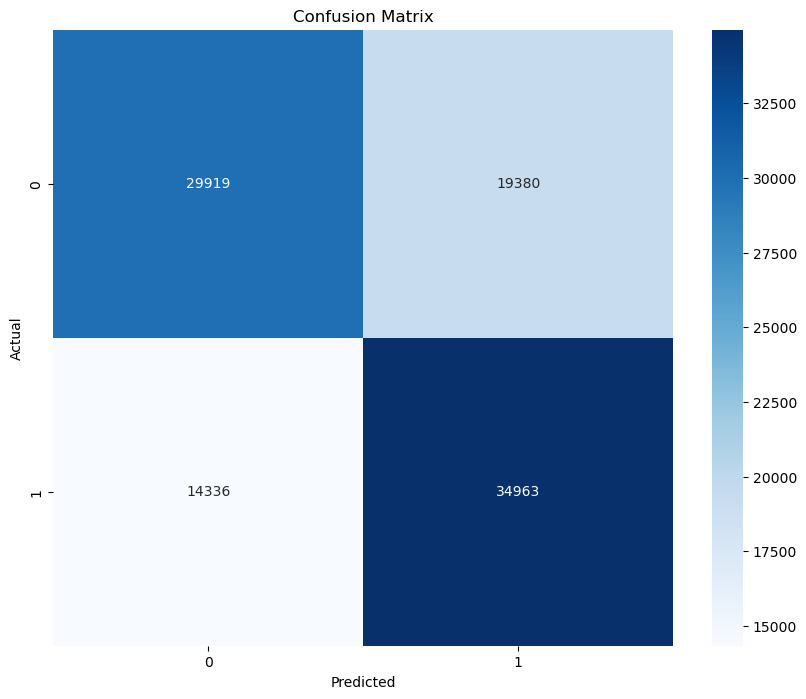

In [463]:
print("Ma trận nhầm lẫn trên tập train:")
cm = confusion_matrix(y_train_new, y_train_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png")

In [451]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.88      0.60      0.72     21128
           1       0.32      0.70      0.43      5597

    accuracy                           0.62     26725
   macro avg       0.60      0.65      0.57     26725
weighted avg       0.76      0.62      0.66     26725



Ma trận nhầm lẫn trên tập test:


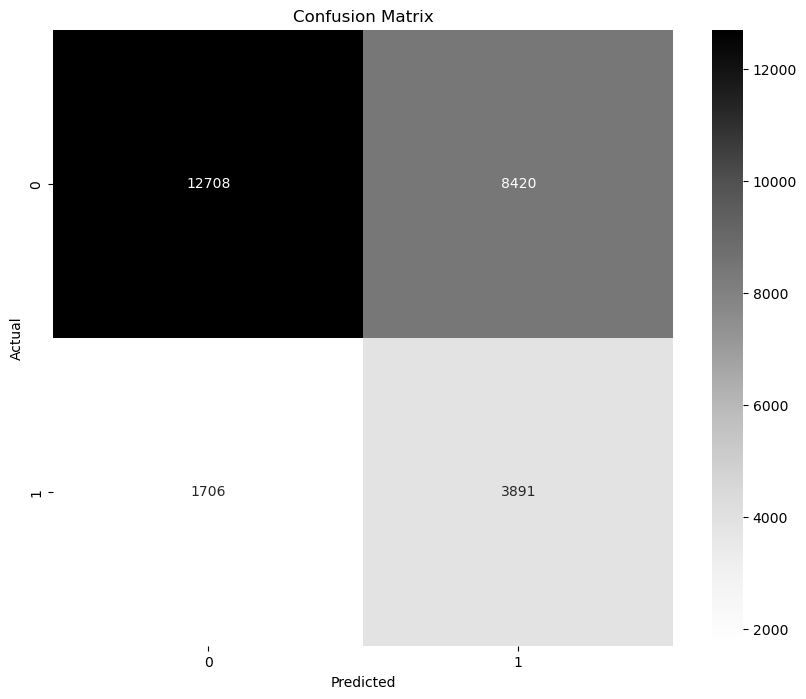

In [449]:
print("Ma trận nhầm lẫn trên tập test:")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greys')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png")

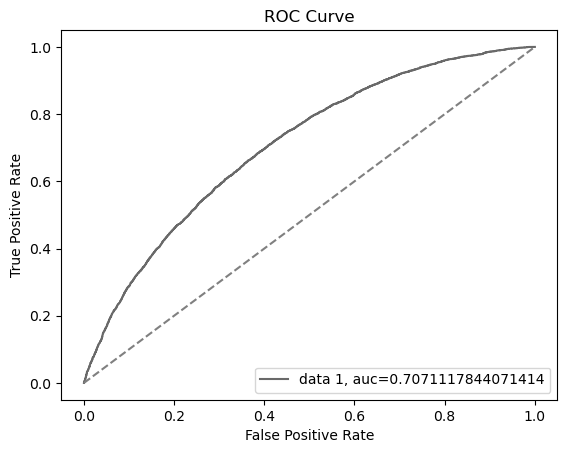

In [461]:
y_pred_proba = model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.plot(fpr,tpr,color='dimgray',label="data 1, auc="+str(auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.legend(loc=4)
plt.savefig('ROC Curve')

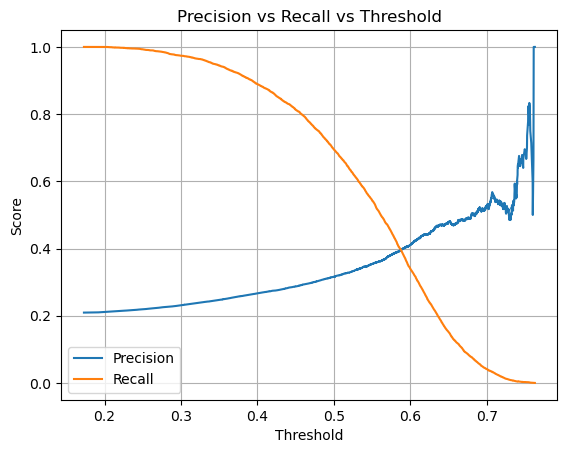

In [435]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall vs Threshold")
plt.legend()
plt.grid()
plt.show()
